# Setup

In [1]:
%%capture
!pip3 install transformers
!pip3 install torchtext
!python3 -m spacy download en_core_web_md
!python3 -m spacy download en

In [82]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [83]:
import pandas as pd
from pathlib import Path
import numpy as np
from numpy import asarray as array
import spacy
from transformers import BertTokenizer

In [84]:
nlp = spacy.load('en_core_web_md') #48 MB

In [85]:
DATA = Path('/home/sharif/Documents/real-or-not/data')
train, test = pd.read_csv(DATA/'train.csv'), pd.read_csv(DATA/'test.csv')

# EDA

TODO: 1 percentage vs 0 percentage?

In [6]:
len(train), len(test)

(7613, 3263)

## Train Data

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Target

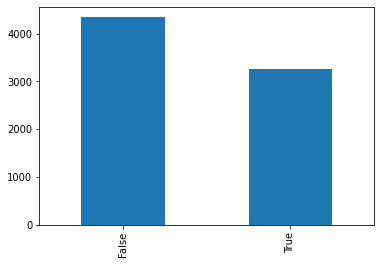

In [8]:
(train.target == 1).value_counts().plot.bar();

### Text

Interesting features:
- All caps
- Links (YouTube)
- !?

In [9]:
for i in range(10): train.text.loc[i]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'Forest fire near La Ronge Sask. Canada'

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

'13,000 people receive #wildfires evacuation orders in California '

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

"I'm on top of the hill and I can see a fire in the woods..."

"There's an emergency evacuation happening now in the building across the street"

"I'm afraid that the tornado is coming to our area..."

### Keywoard

%20 stands for space.

In [10]:
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
train.keyword.isna().sum()

61

### Location

In [12]:
train.location.value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
the burrow                      1
Rafael castillo                 1
The Orwellion police-state      1
Louisville, KY                  1
SoCal                           1
Name: location, Length: 3341, dtype: int64

In [13]:
train.location.isna().sum()

2533

## Test Data

In [14]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Torch text data format

In [397]:
from torchtext import data
from torchtext import datasets

In [398]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [399]:
train_fields = {'text'   : ('text', TEXT),
              'target'  : ('label', LABEL)}

In [400]:
test_fields = {'text'    : ('text', TEXT)}

In [401]:
test_data = data.TabularDataset(
                            path = 'data/test.csv',
                            format = 'csv',
                            fields = test_fields
)

In [402]:
train_data = data.TabularDataset(
                            path = 'data/train.csv',
                            format = 'csv',
                            fields = train_fields
)

In [403]:
print(vars(train_data[0]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'label': '1'}


In [404]:
import random

train_data, valid_data = train_data.split()

In [405]:
len(train_data), len(valid_data)

(5329, 2284)

In [406]:
MAX_VOCAB_SIZE = 25_000

In [407]:
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [408]:
LABEL.build_vocab(train_data)

In [409]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [410]:
for b in train_iterator:
    print(b.label)
    break

tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 0., 0.], device='cuda:0')


In [411]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        text_lengths = text_lengths.cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [412]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [413]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,382,357 trainable parameters


In [414]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20717, 100])


In [415]:
model.embedding.weight.data.copy_(pretrained_embeddings);

In [416]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [417]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [418]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [419]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [420]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        b = batch.label.squeeze()
        b = b.type_as(predictions)
        loss = criterion(predictions, b)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [421]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            b = batch.label.squeeze()
            b = b.type_as(predictions)
            loss = criterion(predictions, b)
            
            loss = criterion(predictions, b)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [422]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [424]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.385 | Train Acc: 83.69%
	 Val. Loss: 0.477 |  Val. Acc: 78.18%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.351 | Train Acc: 85.12%
	 Val. Loss: 0.493 |  Val. Acc: 79.03%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.323 | Train Acc: 85.94%
	 Val. Loss: 0.501 |  Val. Acc: 78.62%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.285 | Train Acc: 88.30%
	 Val. Loss: 0.520 |  Val. Acc: 79.47%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 89.41%
	 Val. Loss: 0.559 |  Val. Acc: 77.27%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.230 | Train Acc: 90.56%
	 Val. Loss: 0.618 |  Val. Acc: 77.38%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.213 | Train Acc: 91.80%
	 Val. Loss: 0.654 |  Val. Acc: 78.16%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.193 | Train Acc: 92.62%
	 Val. Loss: 0.643 |  Val. Acc: 78.62%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.177 | Train Acc: 92.84%
	 Val. Loss: 0.670 |  Val. Acc: 75.80%
Epoch: 10 | Epoch Time: 0m 1

# Helpers

In [15]:
def random_idx(): return np.random.randint(0, len(train))
def random_txt(): return train.text.sample().item()
def txt_by_idx(idx): return train.loc[train.id == idx].text.item()

# NLP

TODO: Look at mean, std of word embedding vectors.

https://spacy.io/usage/vectors-similarity

In [16]:
sentence = random_txt(); sentence

"12' 72W CREE LED Work Light Bar Alloy Spot Flood Combo Diving Offroad 4WD Boat - Full read\x89Û_ http://t.co/MJMwA72ER6 http://t.co/ADx9iYi246"

## Word2Vec

#### If the word is not recognizable by spacy the word embedding contains only 0. These can be removed.

In [17]:
doc = nlp(sentence)
assert len(doc[0].vector) == 300

for token in doc: 
    if not np.any(token.vector): str(token)

'72W'

'read\x89Û'

'http://t.co/MJMwA72ER6'

'http://t.co/ADx9iYi246'

In [18]:
def is_all_zeros(x): return not np.any(x)

assert is_all_zeros(np.array([1,0,0])) == False
assert is_all_zeros(np.array([0,0,0])) == True

In [19]:
def vectorize(sentence):
    doc = nlp(sentence)
    return array([token.vector for token in doc if not is_all_zeros(token.vector)])

## Tokenization

### Spacy

In [20]:
doc = nlp(sentence)
[token.text for token in doc]

['12',
 "'",
 '72W',
 'CREE',
 'LED',
 'Work',
 'Light',
 'Bar',
 'Alloy',
 'Spot',
 'Flood',
 'Combo',
 'Diving',
 'Offroad',
 '4WD',
 'Boat',
 '-',
 'Full',
 'read\x89Û',
 '_',
 'http://t.co/MJMwA72ER6',
 'http://t.co/ADx9iYi246']

### Gensim

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');

In [22]:
tokenizer.tokenize(sentence)

['12',
 "'",
 '72',
 '##w',
 'cree',
 'led',
 'work',
 'light',
 'bar',
 'alloy',
 'spot',
 'flood',
 'combo',
 'diving',
 'off',
 '##ro',
 '##ad',
 '4',
 '##wd',
 'boat',
 '-',
 'full',
 'read',
 '##u',
 '_',
 'http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'm',
 '##jm',
 '##wa',
 '##7',
 '##2',
 '##er',
 '##6',
 'http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'ad',
 '##x',
 '##9',
 '##iy',
 '##i',
 '##24',
 '##6']

# Model

TODO: Batching (padding?)

In [23]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext import data
import torch.optim as optim

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model

In [60]:
IN = 300
N_HIDDEN = 300
N_LAYERS = 3
OUT = 1
BIDIRECTIONAL = True

In [80]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm     = nn.LSTM(IN, N_HIDDEN, N_LAYERS, bidirectional=BIDIRECTIONAL)
        self.fc       = nn.Linear(N_HIDDEN, OUT)
        #self.max_pool = nn.MaxPool1d(3)
        #self.bn       = nn.BatchNorm1d(18)
    def forward(self, x):
        y, (hidden, cell) = self.lstm(x)
        #y                 = self.max_pool(hidden)
        #y                 = F.dropout(y)
        #y                 = self.bn(y)
        y                 = self.fc(hidden[-1,None,-1])
        return y

### Dataset

In [44]:
class TextDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        row = self.data.loc[idx]
        x = tensor(vectorize(row.text))
        y = tensor([row.target]).float()
        return x.to(device), y.to(device), row.text

In [45]:
ds = TextDataset(train)
x,y,txt = ds[random_idx()]

In [46]:
assert type(x) == torch.Tensor
assert type(y) == torch.Tensor
assert x.dtype == torch.float32
assert y.dtype == torch.float32
assert x.shape[1] == 300

### Train/Test split

In [47]:
p = 0.7

In [48]:
msk = np.random.rand(len(train)) < p

In [49]:
train_data = train[msk]
valid_data = train[~msk]

len(train_data), len(valid_data)

(5300, 2313)

In [50]:
train_data.reset_index(inplace=True)
valid_data.reset_index(inplace=True)

In [51]:
train_ds = TextDataset(train_data)
valid_ds = TextDataset(valid_data)

In [52]:
len(train_ds), len(valid_ds)

(5300, 2313)

### Dataloader

In [53]:
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

In [54]:
len(train_dl), len(val_dl)

(5300, 2313)

In [55]:
for x,y,_ in train_dl:
    print(y)
    print(x.shape)
    break

tensor([[0.]], device='cuda:0')
torch.Size([1, 19, 300])


### Train

In [66]:
m = LSTM()
m.to(device);
m.train();

In [57]:
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(m.parameters())

In [58]:
def accuracy(y, y_hat): return ((y_hat > 0.5) == bool(y)).item()

In [59]:
for e in range(100):
    losses,accs = [],[]
    for i, (x,y,_) in enumerate(train_dl):
        if i % 1000 == 0: print(i, '/', len(train_dl))
        try: y_hat = m(x)
        except: continue
        l = criterion(y_hat, y)
        accs.append(accuracy(y, y_hat))
        opt.zero_grad()
        l.backward()
        opt.step()
        losses.append(l.item())
    print(round(sum(losses)/len(losses), 2))
    print(sum(accs)/len(accs))

0 / 5300


KeyboardInterrupt: 

In [ ]:
# 1 layer: train: 61, 63, 64, 65, 65
# 2 layer: 60, 65, 66, 68, 68, 70, 71, 72
# 3 layer: 60, 72
# no train: 57, 57